# Pyro HDP-HSMM-Like Code

In [2]:
import pickle
import torch
from collections import defaultdict

In [3]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

# Setup
pyro.clear_param_store()
torch.manual_seed(0)
device = torch.device("cpu")

# Configuration
num_states = 50         # Truncation level (max dies)
#obs_dim = 2             # Coin feature dimension (e.g., PCA/CNN-reduced)
#obs_dim = reduced.shape[1]  # Use 100 if that's your PCA dim

# Load saved features
with open("coin_features_pca_coin_clip.pkl", "rb") as f:
    data = pickle.load(f)

features = data["features"]
labels = data["labels"]
obs_dim = features.shape[1]

# Group features by label
grouped_features = defaultdict(list)
for feat, label in zip(features, labels):
    grouped_features[label].append(feat)

# Convert to torch tensors
group_data = [torch.tensor(v, dtype=torch.float32) for v in grouped_features.values()]
group_names = list(grouped_features.keys())

print(f"Loaded {len(group_data)} groups with {sum(len(g) for g in group_data)} total coins.")
# EXAMPLE DATA
#group_data = [
#    torch.cat(simulate_group([10, 15, 10], [[0, 0], [5, 5], [0, 0]])),
#    torch.cat(simulate_group([20, 10], [[5, 5], [8, -2]])),
#    torch.cat(simulate_group([12, 18], [[0, 0], [8, -2]]))
#]

# Ensure all are float32
#group_data = [seq.float() for seq in group_data]

# --- Hyperparameters for HDP ---
alpha_val = 0.5  # group-level concentration (sparsity in coin-to-die assignment)
gamma_val = 0.5  # global concentration (number of dies)
num_states = 30  # truncation level (max number of dies)
obs_dim = group_data[0].shape[1]  # dimensionality of feature vectors

# --- HDP Mixture Model ---
def model(groups):
    # Stick-breaking construction for beta (global die proportions)
    gamma = torch.tensor(gamma_val)
    beta_k = pyro.sample("beta_k", dist.Beta(1., gamma).expand([num_states]).to_event(1))
    beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)  # include final stick piece

    # Emission parameters (mean and stddev per die)
    mus = pyro.sample("mus", dist.Normal(torch.zeros(num_states, obs_dim), 5.0).to_event(2))
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(num_states, obs_dim)).to_event(2))

    # Group-level assignments
    for g, seq in enumerate(groups):
        alpha = torch.tensor(alpha_val)
        pi = pyro.sample(f"pi_{g}", dist.Dirichlet(alpha * beta[:-1]))

        with pyro.plate(f"obs_{g}", seq.shape[0]):
            z = pyro.sample(f"z_{g}", dist.Categorical(pi), infer={"enumerate": "parallel"})
            pyro.sample(f"x_{g}", dist.Normal(mus[z], sigmas[z]).to_event(1), obs=seq)

# --- Guide (variational approximation) ---
def guide(groups):
    beta_k_q = pyro.param("beta_k_q", lambda: torch.rand(num_states), constraint=dist.constraints.unit_interval)
    pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))

    mus_loc = pyro.param("mus_loc", lambda: torch.randn(num_states, obs_dim))
    mus_scale = pyro.param("mus_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("mus", dist.Normal(mus_loc, mus_scale).to_event(2))

    sigmas_scale = pyro.param("sigmas_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("sigmas", dist.HalfCauchy(sigmas_scale).to_event(2))

    for g in range(len(groups)):
        alpha = torch.tensor(alpha_val)
        beta_k_q = pyro.param("beta_k_q")  # re-use from above
        pi_alpha = alpha * torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])[:-1]
        pyro.sample(f"pi_{g}", dist.Dirichlet(pi_alpha))

# --- Training ---
svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

num_steps = 3000
for step in range(num_steps):
    loss = svi.step(group_data)
    if step % 500 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")


# --- Posterior Visualization ---
#mus_post = pyro.param("mus_loc").detach()
#colors = ['red', 'blue', 'green']

#for i, seq in enumerate(group_data):
#    plt.scatter(seq[:, 0], seq[:, 1], color=colors[i], alpha=0.5, label=f'Group {i+1}')

#plt.scatter(mus_post[:, 0], mus_post[:, 1], color='black', marker='x', s=100, label='Inferred Dies')
#plt.title("Coin Feature Space with Inferred Die Means")
#plt.legend()
#plt.xlabel("Feature 1")
#plt.ylabel("Feature 2")
#plt.tight_layout()
#plt.show()

# Inferred die (state) locations
mus_post = pyro.param("mus_loc").detach().cpu()
colors = plt.cm.get_cmap('tab10', len(group_data))

# Plot group PCA features
for i, (group_tensor, name) in enumerate(zip(group_data, group_names)):
    arr = group_tensor.numpy()
    plt.scatter(arr[:, 0], arr[:, 1], label=name, alpha=0.5, s=10, color=colors(i))

# Plot inferred die means
plt.scatter(mus_post[:, 0], mus_post[:, 1], color='black', marker='x', s=100, label='Inferred Dies')
plt.title("PCA Features with Inferred Die Means (HDP-HMM)")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_3211/2623299966.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1744233410988/work/torch/csrc/utils/tensor_new.cpp:254.)
  group_data = [torch.tensor(v, dtype=torch.float32) for v in grouped_features.values()]
/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'z_7', 'z_8', 'z_0', 'z_6', 'z_3', 'z_9', 'z_5', 'z_4', 'z_1', 'z_2'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


Loaded 10 groups with 1787 total coins.
[0] ELBO: 107869408.16


/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'z_7', 'z_8', 'z_0', 'z_6', 'z_3', 'z_9', 'z_5', 'z_4', 'z_1', 'z_2'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


[500] ELBO: 70906482.85
[1000] ELBO: 180282890.81
[1500] ELBO: 354505683.36
[2000] ELBO: 99463870.51
[2500] ELBO: 23686979.98
[3000] ELBO: 17892454.23
[3500] ELBO: 95902419.61


KeyboardInterrupt: 

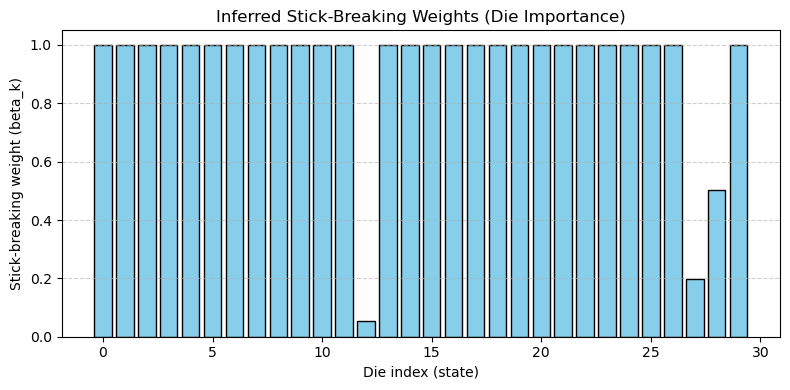

Estimated number of used dies (states): 30 out of 30


In [6]:
# Get stick-breaking weights
beta_k = pyro.param("beta_k_q").detach().cpu().numpy()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(range(len(beta_k)), beta_k, color='skyblue', edgecolor='black')
plt.xlabel("Die index (state)")
plt.ylabel("Stick-breaking weight (beta_k)")
plt.title("Inferred Stick-Breaking Weights (Die Importance)")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Report number of used states
used_states = (beta_k > 0.01).sum()
print(f"Estimated number of used dies (states): {used_states} out of {len(beta_k)}")


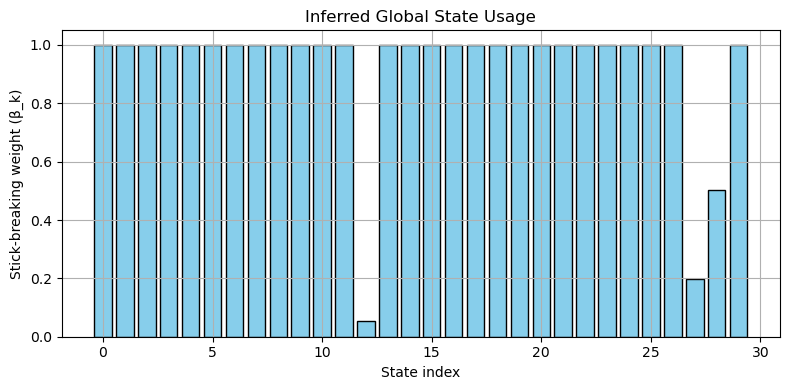

States with β_k > 0.01: 30 / 30

Most common die assignments:
Die 12: 247 coins
Die 5: 162 coins
Die 24: 152 coins
Die 23: 148 coins
Die 28: 147 coins
Die 29: 134 coins
Die 9: 84 coins
Die 13: 70 coins
Die 22: 67 coins
Die 2: 67 coins


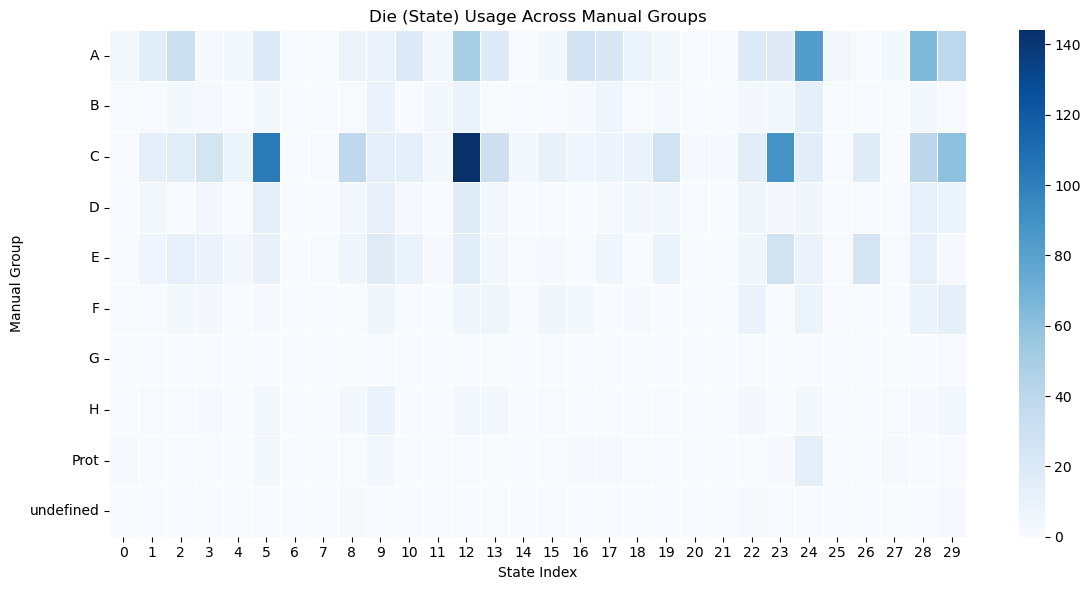

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from collections import Counter

# Load variational parameters
beta_k = pyro.param("beta_k_q").detach().cpu().numpy()
mus = pyro.param("mus_loc").detach().cpu().numpy()

# Plot beta_k (stick-breaking weights)
plt.figure(figsize=(8, 4))
plt.bar(range(len(beta_k)), beta_k, color='skyblue', edgecolor='black')
plt.xlabel("State index")
plt.ylabel("Stick-breaking weight (β_k)")
plt.title("Inferred Global State Usage")
plt.grid(True)
plt.tight_layout()
plt.show()

# Count meaningfully used states (weights > threshold)
threshold = 0.01
meaningful = (beta_k > threshold).sum()
print(f"States with β_k > {threshold}: {meaningful} / {len(beta_k)}")

# Assign each coin to closest mu (state center)
all_features = np.vstack([g.numpy() for g in group_data])
assignments = np.argmin(cdist(all_features, mus), axis=1)
counts = Counter(assignments)

# Show distribution of assignments
used_states = sorted(counts.items(), key=lambda x: x[1], reverse=True)
print("\nMost common die assignments:")
for state_id, count in used_states[:10]:
    print(f"Die {state_id}: {count} coins")

# Optional: visualize usage across original groups
import seaborn as sns
import pandas as pd

group_labels = []
for i, group in enumerate(group_data):
    group_labels += [group_names[i]] * len(group)

df = pd.DataFrame({
    "assigned_state": assignments,
    "group": group_labels
})
heatmap_data = pd.crosstab(df["group"], df["assigned_state"])

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="Blues", linewidths=0.5)
plt.title("Die (State) Usage Across Manual Groups")
plt.xlabel("State Index")
plt.ylabel("Manual Group")
plt.tight_layout()
plt.show()


# Try to get the number of states using ELBO comparison

In [4]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import torch

def train_hdp(
    num_states,
    group_data,
    obs_dim,
    num_steps=5000,
    patience=500,
    min_delta=1e-3,
    verbose=True
):
    

    pyro.clear_param_store()

    elbo_trace = []
    best_loss = float("inf")
    patience_counter = 0

    def model(groups):
        gamma = torch.tensor(1.0)
        beta_k = pyro.sample("beta_k", dist.Beta(1., gamma).expand([num_states]).to_event(1))
        beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)

        mus = pyro.sample("mus", dist.Normal(torch.zeros(num_states, obs_dim), 5.0).to_event(2))
        sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(num_states, obs_dim)).to_event(2))

        for g, seq in enumerate(groups):
            alpha = torch.tensor(1.0)
            pi = pyro.sample(f"pi_{g}", dist.Dirichlet(alpha * beta[:-1]))
            with pyro.plate(f"obs_{g}", seq.shape[0]):
                z = pyro.sample(f"z_{g}", dist.Categorical(pi), infer={"enumerate": "parallel"})
                pyro.sample(f"x_{g}", dist.Normal(mus[z], sigmas[z]).to_event(1), obs=seq)

    def guide(groups):
        beta_k_q = pyro.param("beta_k_q", lambda: torch.rand(num_states), constraint=dist.constraints.unit_interval)
        pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))

        mus_loc = pyro.param("mus_loc", lambda: torch.randn(num_states, obs_dim))
        mus_scale = pyro.param("mus_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
        pyro.sample("mus", dist.Normal(mus_loc, mus_scale).to_event(2))

        sigmas_scale = pyro.param("sigmas_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
        pyro.sample("sigmas", dist.HalfCauchy(sigmas_scale).to_event(2))

        for g in range(len(groups)):
            alpha = torch.tensor(1.0)
            beta_k_q = pyro.param("beta_k_q")
            pi_alpha = alpha * torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])[:-1]
            pyro.sample(f"pi_{g}", dist.Dirichlet(pi_alpha))

    svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

    for step in range(num_steps):
        loss = svi.step(group_data)
        elbo_trace.append(loss)

        if verbose and step % 100 == 0:
            print(f"[{step}] ELBO: {loss:.2f}")

        # Early stopping condition
        if loss + min_delta < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early at step {step}, no improvement for {patience} steps.")
            break

    return elbo_trace



Training with 10 states...
[0] ELBO: 76003066.74
[100] ELBO: 1709015920.14
[200] ELBO: 56487512.92
[300] ELBO: 27253851.25
[400] ELBO: 1403054846.59
[500] ELBO: 414783616.39
[600] ELBO: 131735404.68
[700] ELBO: 18341626.39
[800] ELBO: 65252906.93
Stopping early at step 888, no improvement for 500 steps.


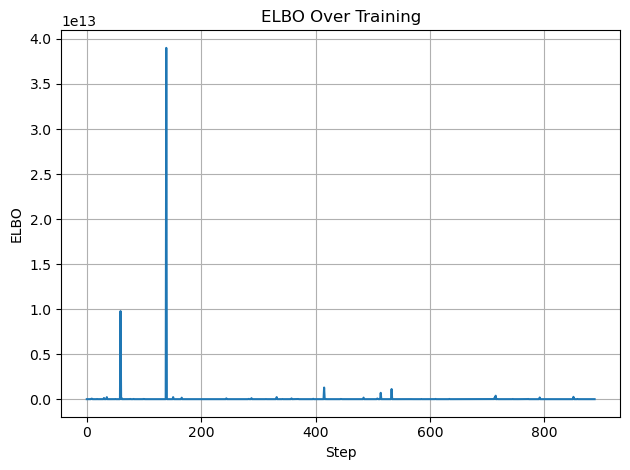


Training with 20 states...
[0] ELBO: 202319891.84
[100] ELBO: 341510525.73
[200] ELBO: 174689324.36
[300] ELBO: 53184951.22
[400] ELBO: 28332094.44
[500] ELBO: 984028325.34
[600] ELBO: 228685596.41
[700] ELBO: 1433821372.14
[800] ELBO: 295993781.77
[900] ELBO: 471160807.97
[1000] ELBO: 52322354.80
[1100] ELBO: 8725122.71
[1200] ELBO: 3848599888.64
[1300] ELBO: 168257781.37
[1400] ELBO: 371428384.59
[1500] ELBO: 13924134.46
[1600] ELBO: 26424167.60
[1700] ELBO: 27803688.95
[1800] ELBO: 195040159.15
[1900] ELBO: 35010682.22
[2000] ELBO: 11871925.99
[2100] ELBO: 11252357.44
[2200] ELBO: 36017181048.69
[2300] ELBO: 25943896.42
[2400] ELBO: 3826451812.27
[2500] ELBO: 12682093.84
[2600] ELBO: 361370255.42
[2700] ELBO: 76101803.46
[2800] ELBO: 42547919.36
Stopping early at step 2851, no improvement for 500 steps.


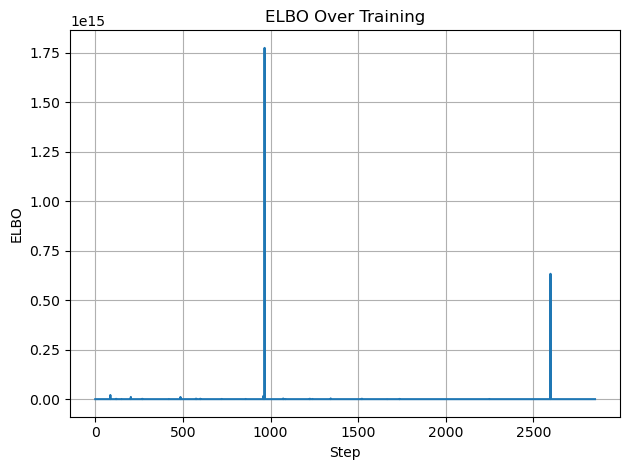


Training with 30 states...
[0] ELBO: 24053965004.44
[100] ELBO: 1034518257.10
[200] ELBO: 131384844.58
[300] ELBO: 445683170.21
[400] ELBO: 872381685.29
[500] ELBO: 833176536.15
[600] ELBO: 253419455.05
[700] ELBO: 25938858.14
[800] ELBO: 129142349.98
[900] ELBO: 143833190.97
[1000] ELBO: 346888881.93
Stopping early at step 1071, no improvement for 500 steps.


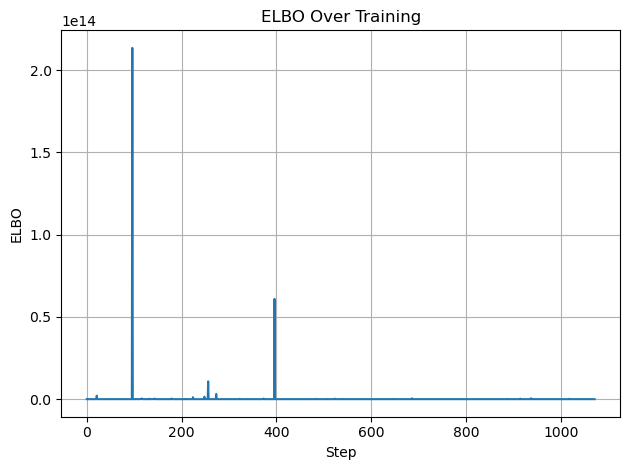


Training with 40 states...
[0] ELBO: 572461291.23
[100] ELBO: 193894049.52
[200] ELBO: 19354379543.28
[300] ELBO: 11978234162.41
[400] ELBO: 297321113.33
[500] ELBO: 387196816.80
[600] ELBO: 103996731.29
[700] ELBO: 1029870740.21
[800] ELBO: 101578007.43
[900] ELBO: 151691387.84
[1000] ELBO: 194410511.19
[1100] ELBO: 827567348.40
[1200] ELBO: 908650171.93
Stopping early at step 1278, no improvement for 500 steps.


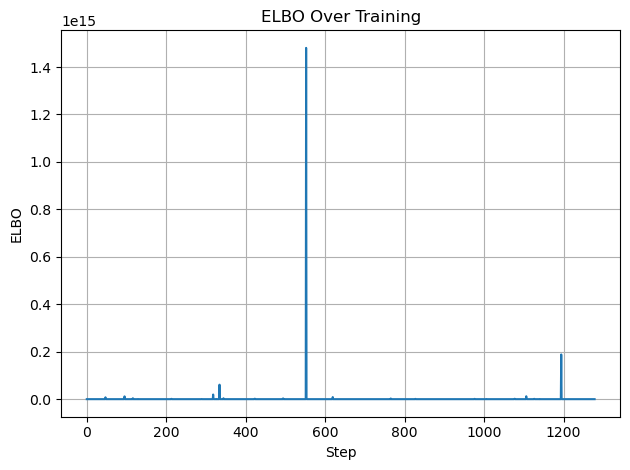


Training with 50 states...
[0] ELBO: 303538094.40
[100] ELBO: 2392360960.79
[200] ELBO: 55704392.09
[300] ELBO: 107506014.97
[400] ELBO: 79622029.90
[500] ELBO: 372043462.98
[600] ELBO: 1145826007.18
[700] ELBO: 150375559.51
[800] ELBO: 755776905.35
[900] ELBO: 98795690.30
[1000] ELBO: 54846207172.85
[1100] ELBO: 256962569.65
[1200] ELBO: 65476878.64
[1300] ELBO: 419861517.58
[1400] ELBO: 1077008056.37
[1500] ELBO: 349526266.74
[1600] ELBO: 2033162671.01
[1700] ELBO: 2815291092.79
[1800] ELBO: 34753222.36
[1900] ELBO: 37088084.53
[2000] ELBO: 788719438.23
Stopping early at step 2008, no improvement for 500 steps.


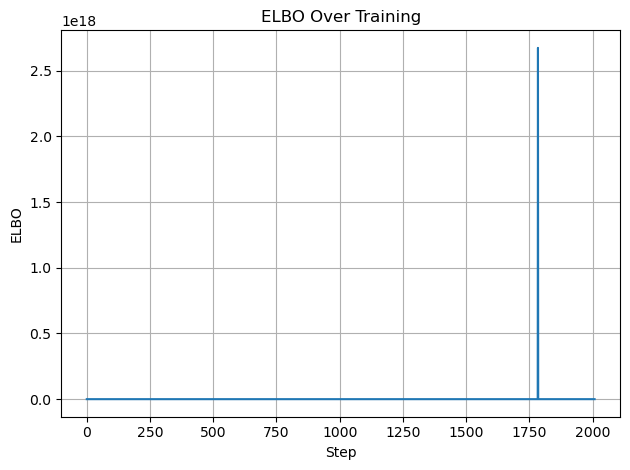


Training with 60 states...
[0] ELBO: 451861651.36
[100] ELBO: 1150960372.03
[200] ELBO: 407037124.09
[300] ELBO: 885362063.56
[400] ELBO: 105525649.31
[500] ELBO: 182682027.68
[600] ELBO: 704299095.66
[700] ELBO: 335558541.21
[800] ELBO: 87781652.32
Stopping early at step 838, no improvement for 500 steps.


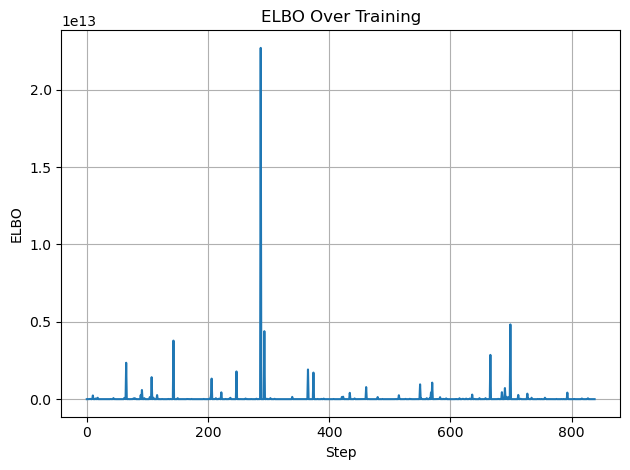


Training with 70 states...
[0] ELBO: 18132223730.39
[100] ELBO: 1084203773.19
[200] ELBO: 371950471.17
[300] ELBO: 916556667.04
[400] ELBO: 428214445.00
[500] ELBO: 467363381.20
[600] ELBO: 113643028.51
[700] ELBO: 51222533399566.03
[800] ELBO: 1795688762.95
[900] ELBO: 750448879.36
[1000] ELBO: 670963111.59
[1100] ELBO: 555560893.30
[1200] ELBO: 625726054.85
[1300] ELBO: 59619367.36
[1400] ELBO: 72981831.59
[1500] ELBO: 411956936.73
[1600] ELBO: 88046501.31
[1700] ELBO: 212290723.74
[1800] ELBO: 166494610.34
[1900] ELBO: 583236773.58
[2000] ELBO: 387657631.51
[2100] ELBO: 34823009.84
[2200] ELBO: 68316013.44
[2300] ELBO: 27583491727567.39
[2400] ELBO: 32425152.37
[2500] ELBO: 10886221.54
[2600] ELBO: 134008801.06
[2700] ELBO: 56135387.49
[2800] ELBO: 41764860.50
[2900] ELBO: 264455193.86
[3000] ELBO: 21125370194256.48
[3100] ELBO: 56405425874.23
[3200] ELBO: 76144144.14
[3300] ELBO: 95459397.42
[3400] ELBO: 61202137.68
[3500] ELBO: 115350461.85
[3600] ELBO: 129370646.32
[3700] ELBO: 

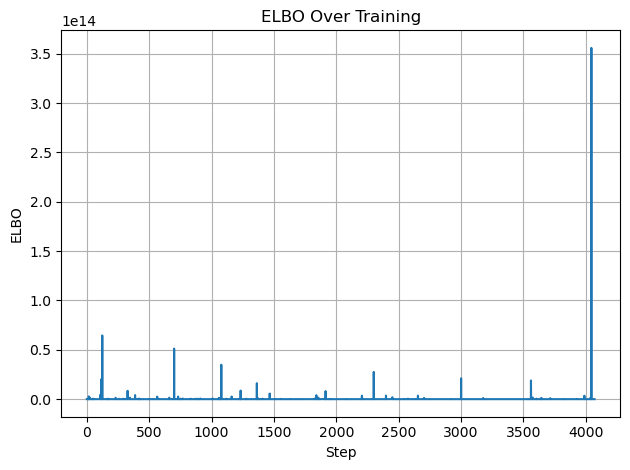


Training with 80 states...
[0] ELBO: 24498684851.19
[100] ELBO: 694817709.47
[200] ELBO: 2198377964.89
[300] ELBO: 1282255207.24
[400] ELBO: 244051359.57
[500] ELBO: 136337644.90
[600] ELBO: 208097825.03
[700] ELBO: 96939830.90
[800] ELBO: 2167578449.10
[900] ELBO: 530521464.99
[1000] ELBO: 974515590.54
Stopping early at step 1013, no improvement for 500 steps.


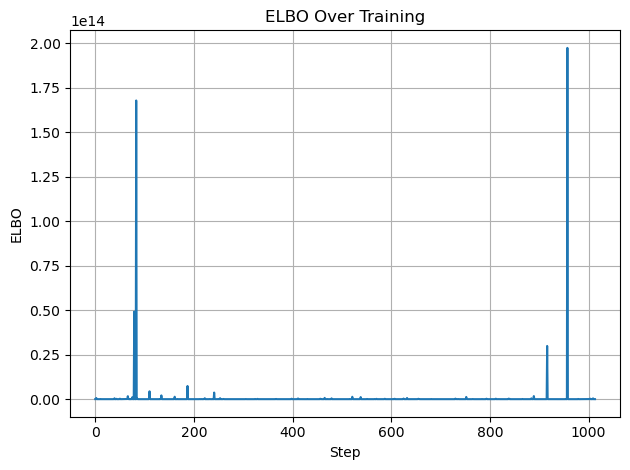


Training with 90 states...
[0] ELBO: 2552719748.10
[100] ELBO: 329932489.72
[200] ELBO: 2954918122.95
[300] ELBO: 162406922.27
[400] ELBO: 9073416762.38
[500] ELBO: 558553678.92
[600] ELBO: 828920378.78
[700] ELBO: 66159021.28
[800] ELBO: 41332557136.35
[900] ELBO: 1406360330.07
[1000] ELBO: 106234034.33
[1100] ELBO: 46033860.01
[1200] ELBO: 84002456.22
[1300] ELBO: 19463120026.24
[1400] ELBO: 77219345.38
[1500] ELBO: 780680562.97
[1600] ELBO: 10365749977.69
[1700] ELBO: 372328407.35
[1800] ELBO: 45823743.73
Stopping early at step 1850, no improvement for 500 steps.


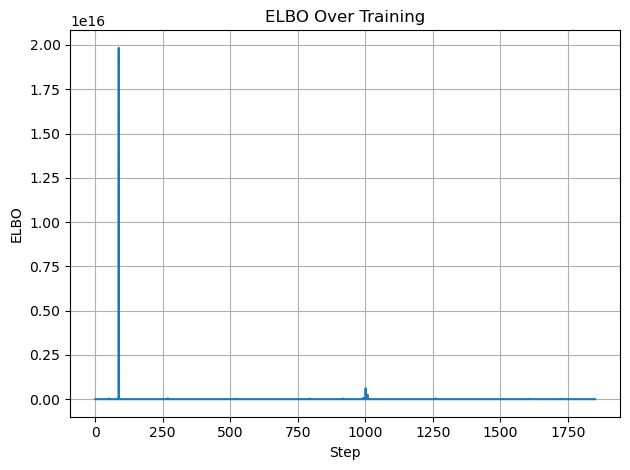


Training with 100 states...
[0] ELBO: 3760168625.80
[100] ELBO: 583444254.39
[200] ELBO: 1501007498.51
[300] ELBO: 447542936.82
[400] ELBO: 189429398.54
[500] ELBO: 210938202.94
[600] ELBO: 6849614667.61
[700] ELBO: 3109030443.95
[800] ELBO: 10660069747.20
[900] ELBO: 74228100597.50
[1000] ELBO: 677996458.33
[1100] ELBO: 112061539926.51
[1200] ELBO: 312574449162.67
[1300] ELBO: 317471968.91
[1400] ELBO: 84281952.90
[1500] ELBO: 270977275.77
Stopping early at step 1594, no improvement for 500 steps.


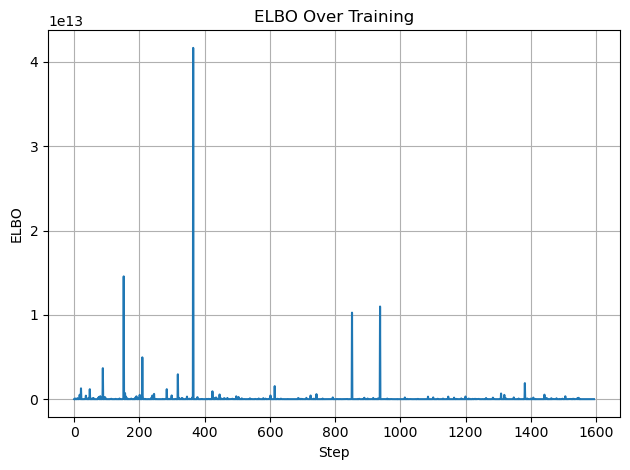

NameError: name 'np' is not defined

In [5]:
import matplotlib.pyplot as plt
state_range = list(range(10, 101, 10))  # Try 10 to 100 states in steps of 10
elbos = []
import numpy as np
for k in state_range:
    print(f"\nTraining with {k} states...")
    elbo_trace = train_hdp(k, group_data, obs_dim=100)
    elbos.append(elbo_trace)
    plt.plot(elbo_trace)
    plt.xlabel("Step")
    plt.ylabel("ELBO")
    plt.title("ELBO Over Training")
    plt.grid(True)
    plt.tight_layout()
    plt.show()





Training with 10 states...
[0] ELBO: 270373981.91
[100] ELBO: 1950268471.67
[200] ELBO: 199796555.08
[300] ELBO: 727473770.46
[400] ELBO: 36378778.21
[500] ELBO: 27262471.05
[600] ELBO: 130124201.69
[700] ELBO: 114530066.74
[800] ELBO: 5428738177.44
[900] ELBO: 599190097.58
[1000] ELBO: 2078311909.77
[1100] ELBO: 38583262.29
[1200] ELBO: 1125774184.16
[1300] ELBO: 97932124.87
[1400] ELBO: 49891133.62
[1500] ELBO: 1242529493.67
[1600] ELBO: 13070050.82
[1700] ELBO: 187199577.55
[1800] ELBO: 27051505.47
[1900] ELBO: 13673162.46
Stopping early at step 1952, no improvement for 500 steps.

Training with 20 states...
[0] ELBO: 128100283.56
[100] ELBO: 7725907788.26
[200] ELBO: 102340837.70
[300] ELBO: 1220337669.20
[400] ELBO: 4503377913.65
[500] ELBO: 394016749.29
[600] ELBO: 184683176.77
[700] ELBO: 112836591.13
[800] ELBO: 1591393544.20
[900] ELBO: 355066210.78
[1000] ELBO: 3243423061.13
[1100] ELBO: 89631129.25
[1200] ELBO: 11840756.44
[1300] ELBO: 675117024.20
Stopping early at step 13

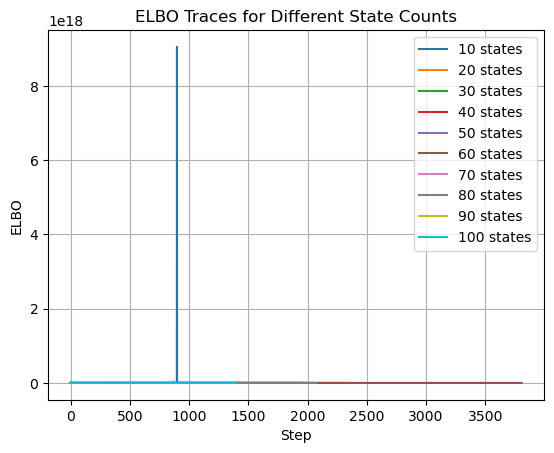

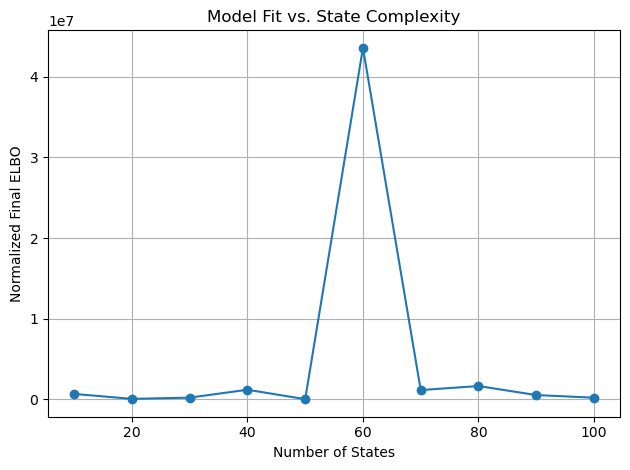

In [11]:
results = []
num_points = sum(len(group) for group in group_data)

for k in state_range:
    print(f"\nTraining with {k} states...")
    elbo_trace = train_hdp(k, group_data, obs_dim=100)
    final_elbo = elbo_trace[-1]
    normalized_elbo = final_elbo / num_points
    results.append({
        "k": k,
        "final_elbo": final_elbo,
        "normalized_elbo": normalized_elbo,
        "elbo_trace": elbo_trace
    })
    plt.plot(elbo_trace, label=f"{k} states")

plt.xlabel("Step")
plt.ylabel("ELBO")
plt.title("ELBO Traces for Different State Counts")
plt.legend()
plt.grid(True)
plt.show()

# Plot summary
plt.plot([r["k"] for r in results], [r["normalized_elbo"] for r in results], marker='o')
plt.xlabel("Number of States")
plt.ylabel("Normalized Final ELBO")
plt.title("Model Fit vs. State Complexity")
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
import pickle

# File path to save
save_path = "elbos.pkl"

# Save features, labels, group names
with open(save_path, "wb") as f:
    pickle.dump(elbos,f)

# File path to save
save_path = "state_range.pkl"

# Save features, labels, group names
with open(save_path, "wb") as f:
    pickle.dump(state_range,f)
print(f"Saved feature data to {save_path}")

Saved feature data to state_range.pkl


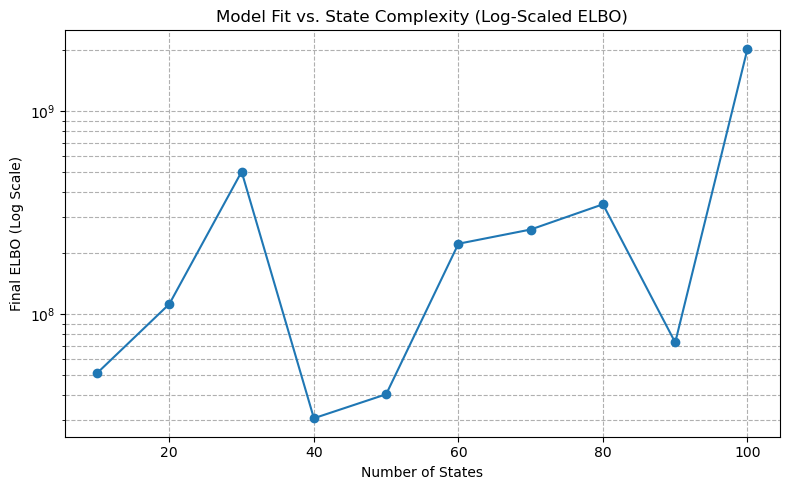

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(filtered_states, filtered_elbos, marker='o')
plt.yscale('log')
plt.title("Model Fit vs. State Complexity (Log-Scaled ELBO)")
plt.xlabel("Number of States")
plt.ylabel("Final ELBO (Log Scale)")
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


# Updated HDP HMM Evaluation Pipeline

In [26]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import torch
import numpy as np
from sklearn.model_selection import train_test_split

import logging

# Configure logging
logging.basicConfig(
    filename="hdp_training.log",  # output file name
    filemode="a",                 # append mode ("w" for overwrite)
    format="%(asctime)s - %(message)s",
    level=logging.INFO
)


def train_hdp(
    num_states,
    group_data,
    obs_dim,
    test_data=None,
    num_steps=3000,
    patience=500,
    min_delta=1e-3,
    verbose=True
):
    pyro.clear_param_store()

    elbo_trace = []
    best_loss = float("inf")
    patience_counter = 0

    def model(groups):
        gamma = torch.tensor(1.0)
        beta_k = pyro.sample("beta_k", dist.Beta(1., gamma).expand([num_states]).to_event(1))
        beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)

        mus = pyro.sample("mus", dist.Normal(torch.zeros(num_states, obs_dim), 5.0).to_event(2))
        sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(num_states, obs_dim)).to_event(2))

        for g, seq in enumerate(groups):
            alpha = torch.tensor(1.0)
            pi = pyro.sample(f"pi_{g}", dist.Dirichlet(alpha * beta[:-1]))
            with pyro.plate(f"obs_{g}", seq.shape[0]):
                z = pyro.sample(f"z_{g}", dist.Categorical(pi), infer={"enumerate": "parallel"})
                pyro.sample(f"x_{g}", dist.Normal(mus[z], sigmas[z]).to_event(1), obs=seq)

    def guide(groups):
        beta_k_q = pyro.param("beta_k_q", lambda: torch.rand(num_states), constraint=dist.constraints.unit_interval)
        pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))

        mus_loc = pyro.param("mus_loc", lambda: torch.randn(num_states, obs_dim))
        mus_scale = pyro.param("mus_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
        pyro.sample("mus", dist.Normal(mus_loc, mus_scale).to_event(2))

        sigmas_scale = pyro.param("sigmas_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
        pyro.sample("sigmas", dist.HalfCauchy(sigmas_scale).to_event(2))

        for g in range(len(groups)):
            beta_k_q = pyro.param("beta_k_q")
            pi_alpha = torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])[:-1]
            pyro.sample(f"pi_{g}", dist.Dirichlet(pi_alpha))

    svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

    for step in range(num_steps):
        loss = svi.step(group_data)
        elbo_trace.append(loss)

        if verbose and step % 100 == 0:
            print(f"[{step}] Loss: {loss:.2f} (ELBO: {-loss:.2f})")

        if loss + min_delta < best_loss:
            if step != 0 and loss == best_loss:
                # Avoid logging same loss repeatedly
                continue
            best_loss = loss
            patience_counter = 0
            msg = f"New best loss at step {step}: {loss}"
            print(msg)
            logging.info(msg)
        else:
            patience_counter += 1
            msg = f"No improvement at step {step} (current loss: {loss}, best: {best_loss}) [patience={patience_counter}]"
            #print(msg)
            logging.info(msg)




        if patience_counter >= patience:
            print(f"Stopping early at step {step}, no improvement for {patience} steps.")
            break

    # --- Count active states ---
    beta_k_q = pyro.param("beta_k_q")
    pi_values = []
    
    for g in range(len(group_data)):
        pi_alpha = torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])[:-1]
        pi = dist.Dirichlet(pi_alpha).mean  # Use the mean of the variational Dirichlet
        pi_values.append(pi)

    avg_pi = torch.stack(pi_values).mean(dim=0)
    active_states = (avg_pi > 0.01).sum().item()

    # --- Predictive log-likelihood (if test set provided) ---
    predictive_ll = None
    if test_data is not None:
        with torch.no_grad():
            mus = pyro.param("mus_loc")
            sigmas = pyro.param("sigmas_scale")
            test_lls = []
            for seq in test_data:
                log_probs = dist.Normal(mus, sigmas).log_prob(seq.unsqueeze(1))  # [T, K, D]
                test_lls.append(log_probs.sum(-1).logsumexp(dim=1).mean().item())
            predictive_ll = np.mean(test_lls)

    return {
        "elbo_trace": elbo_trace,
        "best_elbo": -best_loss,  # Use negative best loss as final ELBO
        "active_states": active_states,
        "predictive_loglik": predictive_ll
    }



Training with 25 states...
[0] Loss: 1395903289.06 (ELBO: -1395903289.06)
New best loss at step 0: 1395903289.063264
New best loss at step 1: 280386919.466918
New best loss at step 4: 25913693.549001694
New best loss at step 51: 16730847.533400536
New best loss at step 71: 15857894.039885521
[100] Loss: 413095854.00 (ELBO: -413095854.00)
New best loss at step 116: 12481890.637821198
New best loss at step 163: 11552651.408298492
[200] Loss: 313031247.09 (ELBO: -313031247.09)
New best loss at step 203: 9596970.391521454
New best loss at step 210: 8318872.014026642
[300] Loss: 50646311.60 (ELBO: -50646311.60)
New best loss at step 301: 6373076.8592300415
[400] Loss: 26520143.80 (ELBO: -26520143.80)
New best loss at step 417: 3800970.0862493515
[500] Loss: 33425035.09 (ELBO: -33425035.09)
New best loss at step 538: 3254631.1687521935
New best loss at step 575: 2861677.350751877
[600] Loss: 5458368.90 (ELBO: -5458368.90)
[700] Loss: 31537048.66 (ELBO: -31537048.66)
[800] Loss: 9875240.58 (

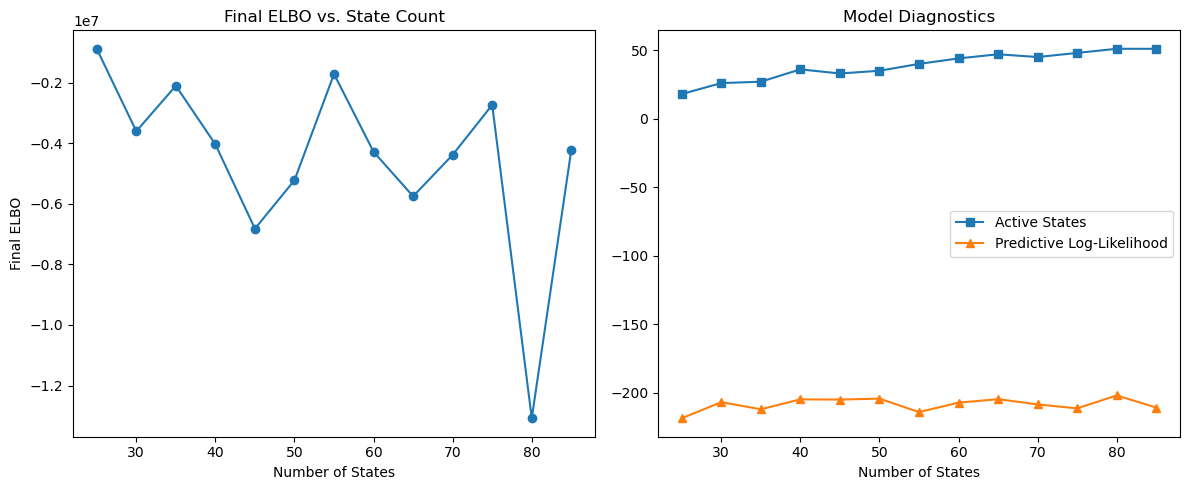

In [27]:
import matplotlib.pyplot as plt

# Split your group data into training and testing groups (if needed)
train_groups, test_groups = train_test_split(group_data, test_size=0.2, random_state=42)

candidate_states = list(range(25, 90, 5))  # Finer granularity around promising range
results = []

for k in candidate_states:
    print(f"\nTraining with {k} states...")
    result = train_hdp(k, train_groups, obs_dim=obs_dim, test_data=test_groups)
    results.append((k, result))

# --- Plot Final ELBO and Active States ---
elbos = [r["best_elbo"] for _, r in results]
actives = [r["active_states"] for _, r in results]
predictive_ll = [r["predictive_loglik"] for _, r in results]
state_counts = [k for k, _ in results]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(state_counts, elbos, marker='o')
plt.xlabel("Number of States")
plt.ylabel("Final ELBO")
plt.title("Final ELBO vs. State Count")

plt.subplot(1, 2, 2)
plt.plot(state_counts, actives, marker='s', label="Active States")
plt.plot(state_counts, predictive_ll, marker='^', label="Predictive Log-Likelihood")
plt.xlabel("Number of States")
plt.title("Model Diagnostics")
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
elbos

[-884282.3766613007,
 -3605839.167954445,
 -2104929.6075582504,
 -4039089.8723983765,
 -6823070.496519089,
 -5223202.893093109,
 -1715564.3086977005,
 -4284786.359808922,
 -5753928.5186805725,
 -4384824.7901678085,
 -2735960.7430057526,
 -13080451.281866074,
 -4222291.680785179]